In [4]:


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


In [6]:
# Randomly select 2500 data points from the training dataset (“Train_rev1.csv”) for ease of analysis. Then 
# split the 2500 data points into training (80%) and test (20%) sets.

def split_data():
    # Load the data
    data = pd.read_csv('data/Train_rev1.csv')
    # Randomly select 2500 data points
    data = data.sample(n=2500)
    # Split the data
    train, test = train_test_split(data, test_size=0.2)
    return train, test

train, test = split_data()

print(train.shape)
print(test.shape)

(2000, 12)
(500, 12)


In [9]:
#reset index
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

train.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,68092952,Head Chef,Joining a thriving restaurant that is forever ...,"Bury, Lancashire Lancashire North West",UK,NaN,permanent,Established Restaurant,Hospitality & Catering Jobs,"From 25,000 to 32,000 per annum + Bonus",28500,totaljobs.com
1,70676461,Concept Mechanical Engineer,EXCELLENT OPPORTUNITY **** CONCEPT MECHANICAL ...,"Leicester,Northampton,Coventry,Milton Keynes,L...",UK,NaN,contract,ATA Recruitment Ltd,Engineering Jobs,40 per hour,76800,jobsite.co.uk
2,68689043,Senior Media Analyst,An immediate opportunity has arisen for an exp...,City London South East,London,NaN,permanent,Randstad Financial & Professional,Creative & Design Jobs,"37000 - 42000 per annum + Study Support, Bonus...",39500,totaljobs.com
3,71091854,Deputy Manager Liverpool,"Deputy Manager – Job Description NEW YEAR, NEW...",Liverpool,Liverpool,full_time,NaN,Cardea Resourcing,Healthcare & Nursing Jobs,"27,000 - 27,300/Year",27150,staffnurse.com
4,68706364,Hotel Contract Manager French Market,Contracts Manager Based in London OR Paris ***...,West London London South East,East Sheen,NaN,permanent,New Frontiers,Travel Jobs,30k - 38k per year,34000,totaljobs.com


In [11]:
#target column = high if salary >= 75% percentile otherwise low
salary_75 = train['SalaryNormalized'].quantile(0.75)
print('75th percentile salary',salary_75)

train['target'] = np.where(train['SalaryNormalized'] >= salary_75, 'high', 'low')
test['target'] = np.where(test['SalaryNormalized'] >= salary_75, 'high', 'low')




75th percentile salary 42500.0


In [18]:
train = train[['FullDescription', 'target']]
test = test[['FullDescription', 'target']]

train.to_csv('data Pre-Processed/train.csv', index=False)
test.to_csv('data Pre-Processed/test.csv', index=False)

train.shape, test.shape

((2000, 2), (500, 2))

In [19]:
train.head()

,FullDescription,target
0,Joining a thriving restaurant that is forever ...,low
1,EXCELLENT OPPORTUNITY **** CONCEPT MECHANICAL ...,high
2,An immediate opportunity has arisen for an exp...,low
3,"Deputy Manager – Job Description NEW YEAR, NEW...",low
4,Contracts Manager Based in London OR Paris ***...,low


In [24]:
#target count and percentage
train['target'].value_counts(), train['target'].value_counts(normalize=True)





(target
 low     1485
 high     515
 Name: count, dtype: int64,
 target
 low     0.7425
 high    0.2575
 Name: proportion, dtype: float64)

In [69]:
#target count and percentage
test['target'].value_counts(), test['target'].value_counts(normalize=True)


(target
 low     381
 high    119
 Name: count, dtype: int64,
 target
 low     0.762
 high    0.238
 Name: proportion, dtype: float64)

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import nltk
from sklearn.naive_bayes import BernoulliNB


# Download NLTK stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/krishan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/krishan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [59]:
train = pd.read_csv('data Pre-Processed/train.csv')
test = pd.read_csv('data Pre-Processed/test.csv')

# Preprocessing function to clean text data
def clean_text(text):
    # Remove non-alphabetic characters and lowercase the text
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    # Join the tokens back into a string
    text = ' '.join(tokens)
    return text

# lametize the words
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    text = ' '.join(tokens)
    return text

# Preprocess the text data
train['FullDescription'] = train['FullDescription'].apply(clean_text).apply(lemmatize_words)
test['FullDescription'] = test['FullDescription'].apply(clean_text).apply(lemmatize_words)


train.head()


[nltk_data] Downloading package wordnet to /Users/krishan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,FullDescription,target
0,joining thriving restaurant forever expanding ...,low
1,excellent opportunity concept mechanical engin...,high
2,immediate opportunity arisen experienced senio...,low
3,deputy manager job description new year new jo...,low
4,contract manager based london paris contract m...,low


In [64]:
# Making word Embeddings Using TF-IDF
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()
# Fit the vectorizer to the training data
X_train = vectorizer.fit_transform(train['FullDescription'])

# Transform the test data
X_test = vectorizer.transform(test['FullDescription'])

X_train.shape, X_test.shape

((2000, 13909), (500, 13909))

In [77]:
X_train=X_train.toarray()
X_test=X_test.toarray()

# Train a Naive Bayes classifier
model = BernoulliNB()

# Fit the model to the training data
model.fit(X_train, train['target'])

# Predict the target
train['predicted'] = model.predict(X_train)
test['predicted'] = model.predict(X_test)

# Calculate the accuracy
train_accuracy = accuracy_score(train['target'], train['predicted'])
test_accuracy = accuracy_score(test['target'], test['predicted'])

print('Train accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)

Train accuracy: 0.8875
Test accuracy: 0.806


In [79]:
# hyperparameter tuning


# Create a pipeline
model = make_pipeline(TfidfVectorizer(), BernoulliNB())

# Create a grid of hyperparameters
param_grid = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidfvectorizer__max_features': [1000, 10000, 30000],
    'tfidfvectorizer__use_idf': [True, False],
    'tfidfvectorizer__norm': ['l1', 'l2'],
    'bernoullinb__alpha': [0.1, 1, 2]
}

# Perform a grid search of the pipeline
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid.fit(train['FullDescription'], train['target'])

# Print the best hyperparameters
print('Best hyperparameters:', grid.best_params_)
print('Best cross-validation score:', grid.best_score_)
print('Test score:', grid.score(test['FullDescription'], test['target']))

# Predict the target
train['predicted'] = grid.predict(train['FullDescription'])
test['predicted'] = grid.predict(test['FullDescription'])

# Calculate the accuracy
train_accuracy = accuracy_score(train['target'], train['predicted'])
test_accuracy = accuracy_score(test['target'], test['predicted'])


print('Train accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)


Best hyperparameters: {'bernoullinb__alpha': 0.1, 'tfidfvectorizer__max_features': 30000, 'tfidfvectorizer__ngram_range': (1, 2), 'tfidfvectorizer__norm': 'l1', 'tfidfvectorizer__use_idf': True}
Best cross-validation score: 0.7950000000000002
Test score: 0.822
Train accuracy: 0.96
Test accuracy: 0.822


Confusion Matrix:
[[ 69  50]
 [ 39 342]]


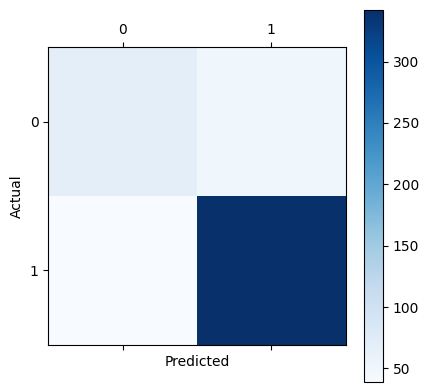

In [81]:
# Create confusion matrix
cm = confusion_matrix(test["target"], test["predicted"])

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix 
plt.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [82]:
# Best hyperparameters: {'bernoullinb__alpha': 0.1, 'tfidfvectorizer__max_features': 30000, 'tfidfvectorizer__ngram_range': (1, 2), 'tfidfvectorizer__norm': 'l1', 'tfidfvectorizer__use_idf': True}

vectorizer = TfidfVectorizer(max_features=30000, ngram_range=(1, 2), norm='l1', use_idf=True)
X_train = vectorizer.fit_transform(train['FullDescription'])
X_test = vectorizer.transform(test['FullDescription'])

model = BernoulliNB(alpha=0.1)
model.fit(X_train.toarray(), train['target'])

train['predicted'] = model.predict(X_train.toarray())
test['predicted'] = model.predict(X_test.toarray())

train_accuracy = accuracy_score(train['target'], train['predicted'])
test_accuracy = accuracy_score(test['target'], test['predicted'])

print('Train accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)




Train accuracy: 0.96
Test accuracy: 0.822


In [87]:
# top 10 features for high and low salary
# Extract the feature names from the TF-IDF vectorizer
feature_names = np.array(vectorizer.get_feature_names_out())

# Extract the feature log probabilities from the Naive Bayes model
feature_log_prob = model.feature_log_prob_

# Create a DataFrame of the features and their log probabilities
feature_prob = pd.DataFrame({'high': feature_log_prob[1], 'low': feature_log_prob[0]}, index=feature_names)


# Sort the features by the difference in log probabilities
feature_prob['diff'] = feature_prob['high'] - feature_prob['low']
feature_prob = feature_prob.sort_values('diff', ascending=False)

# Print the top 10 features for high and low salary
print('Top 10 features for high salary:')
feature_prob.head(10)






Top 10 features for high salary:


,high,low,diff
meal,-3.663090,-8.54714,4.884050
curriculum,-3.866097,-8.54714,4.681043
absence,-3.898780,-8.54714,4.648361
pupil,-4.003771,-8.54714,4.543369
gcse,-4.003771,-8.54714,4.543369
professional manner,-4.041369,-8.54714,4.505771
hour work,-4.121093,-8.54714,4.426047
time hour,-4.121093,-8.54714,4.426047
classroom,-4.121093,-8.54714,4.426047
customer focused,-4.163472,-8.54714,4.383668


In [88]:
# Print the top 10 features for low salary
print('Top 10 features for low salary:')
feature_prob.tail(10)



Top 10 features for low salary:


,high,low,diff
senior quantity,-9.60589,-4.436266,-5.169623
senior project,-9.60589,-4.436266,-5.169623
ssa,-9.60589,-4.436266,-5.169623
annual revenue,-9.60589,-4.436266,-5.169623
internal control,-9.60589,-4.436266,-5.169623
chief,-9.60589,-4.284460,-5.321429
vp,-9.60589,-4.284460,-5.321429
saas,-9.60589,-4.284460,-5.321429
industry best,-9.60589,-4.152691,-5.453199
top tier,-9.60589,-4.036281,-5.569609


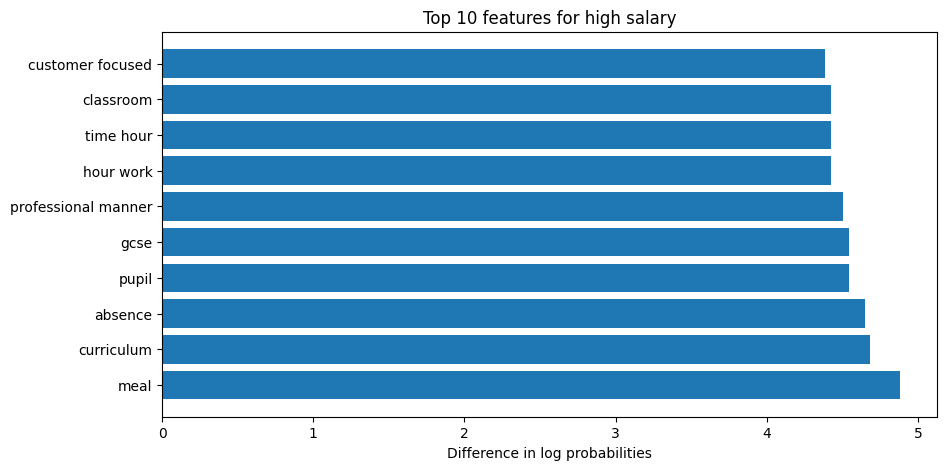

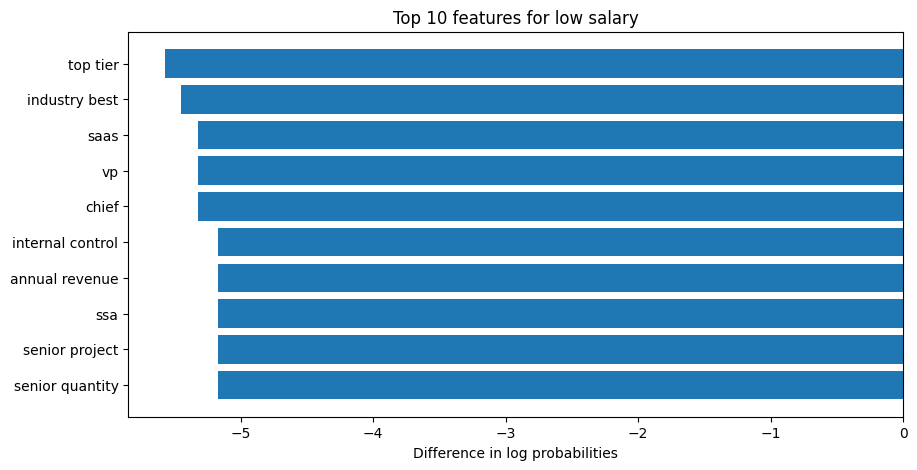

In [89]:
# plot the top 10 features for high and low salary
# Plot the top 10 features for high salary
plt.figure(figsize=(10, 5))
plt.barh(feature_prob.index[:10], feature_prob['diff'].head(10))
plt.xlabel('Difference in log probabilities')
plt.title('Top 10 features for high salary')
plt.show()

# Plot the top 10 features for low salary
plt.figure(figsize=(10, 5))
plt.barh(feature_prob.index[-10:], feature_prob['diff'].tail(10))
plt.xlabel('Difference in log probabilities')
plt.title('Top 10 features for low salary')
plt.show()

